In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.svm import SVC
import pickle
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
import seaborn as sns

In [5]:
df = pd.read_csv('train.csv')
print(df['price'].unique(), df['is_business_travel_ready'].unique(), df['host_is_superhost'].unique(), df['instant_bookable'].unique())
df.drop('is_business_travel_ready', axis=1, inplace=True)
df.drop('last_review', axis=1, inplace=True)
df.drop('host_since', axis=1, inplace=True)
df.head()


[2 1 3 4] ['f'] ['t' 'f'] ['t' 'f']


,id,neighbourhood,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_is_superhost,bathrooms,...,bed_type,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,727,Palermo,Entire home/apt,1,170,2.48,4,346,t,1.0,...,Real Bed,2092,1,0,365,t,strict_14_with_grace_period,f,f,2
1,6274,Colegiales,Private room,1,11,0.57,1,0,t,1.0,...,Real Bed,558,1,0,15,f,moderate,f,f,1
2,6025,Recoleta,Entire home/apt,3,2,0.08,19,360,f,1.0,...,Real Bed,1052,3,351,90,t,moderate,f,f,3
3,8931,Recoleta,Entire home/apt,2,1,0.13,1,267,f,1.0,...,Real Bed,0,4,0,1125,t,flexible,f,f,2
4,7524,San Nicolás,Entire home/apt,2,31,1.54,5,365,t,1.0,...,Real Bed,2092,1,0,365,t,moderate,f,f,3


# Preliminary LabelEncoding (for Heatmap visualization only)

In [6]:
neighbourhood_encoder = LabelEncoder()
room_type_encoder = LabelEncoder()
bed_type_encoder = LabelEncoder()
cancellation_policy_encoder = LabelEncoder()
df['neighbourhood'] = neighbourhood_encoder.fit_transform(df.neighbourhood.values)
df['room_type'] = room_type_encoder.fit_transform(df.room_type.values)
df['bed_type'] = bed_type_encoder.fit_transform(df.bed_type.values)
df['cancellation_policy'] = cancellation_policy_encoder.fit_transform(df.cancellation_policy.values)

df['host_is_superhost'] = df.host_is_superhost.map(dict(t=2, f=1))
df['instant_bookable'] = df.instant_bookable.map(dict(t=2, f=1))
df['require_guest_profile_picture'] = df.require_guest_profile_picture.map(dict(t=2, f=1))
df['require_guest_phone_verification'] = df.require_guest_phone_verification.map(dict(t=2, f=1))

df.head(5)

,id,neighbourhood,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_is_superhost,bathrooms,...,bed_type,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,727,21,0,1,170,2.48,4,346,2,1.0,...,4,2092,1,0,365,2,2,1,1,2
1,6274,9,2,1,11,0.57,1,0,2,1.0,...,4,558,1,0,15,1,1,1,1,1
2,6025,27,0,3,2,0.08,19,360,1,1.0,...,4,1052,3,351,90,2,1,1,1,3
3,8931,27,0,2,1,0.13,1,267,1,1.0,...,4,0,4,0,1125,2,0,1,1,2
4,7524,31,0,2,31,1.54,5,365,2,1.0,...,4,2092,1,0,365,2,1,1,1,3


In [7]:
names = list(df)
print(names)
df_data = df[names[2:]]
df_train, df_test = train_test_split(df_data, test_size=0.15)
print(df.shape, df_train.shape, df_test.shape)
print(df_train['price'].unique(), df_train['host_is_superhost'].unique(), df_train['instant_bookable'].unique())
df_train.head(5)

['id', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'price']
(9681, 22) (8228, 20) (1453, 20)
[2 1 4 3] [2 1] [2 1]


,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_is_superhost,bathrooms,bedrooms,beds,bed_type,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
8974,0,3,51,2.52,1,186,2,1.0,1,4,4,1399,2,0,90,2,0,1,1,2
5541,0,1,32,2.09,1,67,2,1.0,0,2,4,550,1,0,1125,1,2,1,1,1
6981,0,3,1,0.32,1,360,1,2.0,2,3,4,1749,1,700,1125,1,1,1,1,4
7698,0,14,8,0.43,1,90,1,1.0,1,4,4,800,1,0,1125,1,0,1,1,2
5383,0,30,21,1.30,1,266,2,1.0,0,1,4,2802,1,0,1125,1,2,1,1,3


# Correlation Heatmap

<AxesSubplot:>

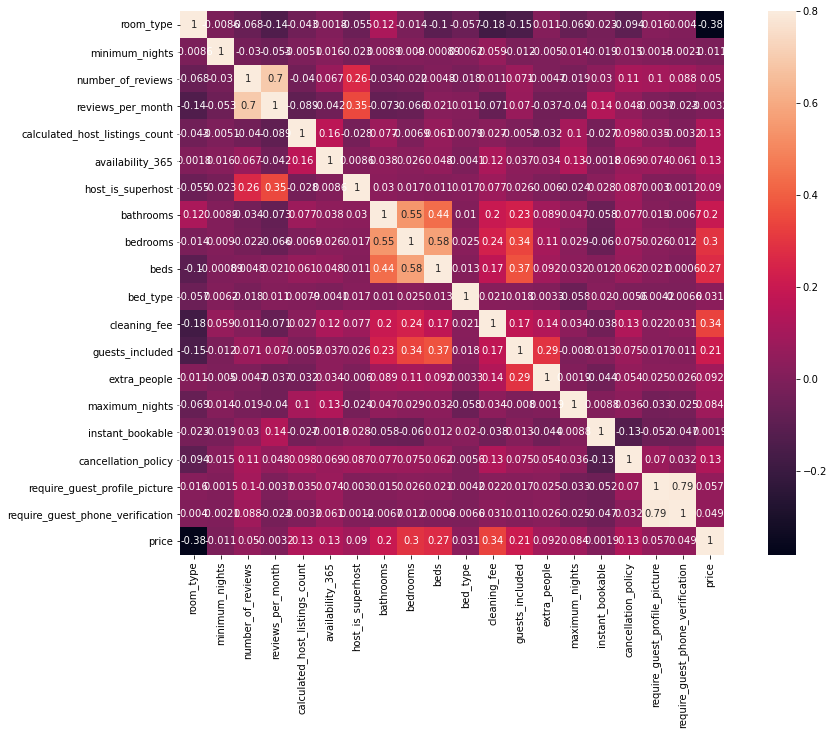

In [8]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

# Reloading data

In [10]:
raw_data = pd.read_csv("train.csv",encoding="utf_8_sig")
print(raw_data.shape)
print(list(raw_data), len(list(raw_data)))
raw_data.head()

(9681, 25)
['id', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_since', 'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'price'] 25


,id,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,...,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,727,Palermo,Entire home/apt,1,170,5/12/20,2.48,4,346,8/1/13,...,2092,1,0,365,t,f,strict_14_with_grace_period,f,f,2
1,6274,Colegiales,Private room,1,11,7/1/19,0.57,1,0,2/14/14,...,558,1,0,15,f,f,moderate,f,f,1
2,6025,Recoleta,Entire home/apt,3,2,11/23/19,0.08,19,360,10/19/17,...,1052,3,351,90,t,f,moderate,f,f,3
3,8931,Recoleta,Entire home/apt,2,1,11/1/19,0.13,1,267,2/1/19,...,0,4,0,1125,t,f,flexible,f,f,2
4,7524,San Nicolás,Entire home/apt,2,31,12/26/19,1.54,5,365,1/24/15,...,2092,1,0,365,t,f,moderate,f,f,3


neighbourhood, room_type, bathrooms, bedrooms, beds, bed_type

minimum_nights, maximum_nights, availability_365, guests_included, extra_people

instant_bookable, cancellation_policy, require_guest_profile_picture, require_guest_phone_verification, cleaning_fee

number_of_reviews, last_review, reviews_per_month

host_since, calculated_host_listings_count, host_is_superhost

In [11]:
raw_data.drop('id', axis=1, inplace=True)
raw_data.drop('is_business_travel_ready', axis=1, inplace=True)
raw_data.head()

,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,host_is_superhost,...,bed_type,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,Palermo,Entire home/apt,1,170,5/12/20,2.48,4,346,8/1/13,t,...,Real Bed,2092,1,0,365,t,strict_14_with_grace_period,f,f,2
1,Colegiales,Private room,1,11,7/1/19,0.57,1,0,2/14/14,t,...,Real Bed,558,1,0,15,f,moderate,f,f,1
2,Recoleta,Entire home/apt,3,2,11/23/19,0.08,19,360,10/19/17,f,...,Real Bed,1052,3,351,90,t,moderate,f,f,3
3,Recoleta,Entire home/apt,2,1,11/1/19,0.13,1,267,2/1/19,f,...,Real Bed,0,4,0,1125,t,flexible,f,f,2
4,San Nicolás,Entire home/apt,2,31,12/26/19,1.54,5,365,1/24/15,t,...,Real Bed,2092,1,0,365,t,moderate,f,f,3


# Exploring neighbourhood feature

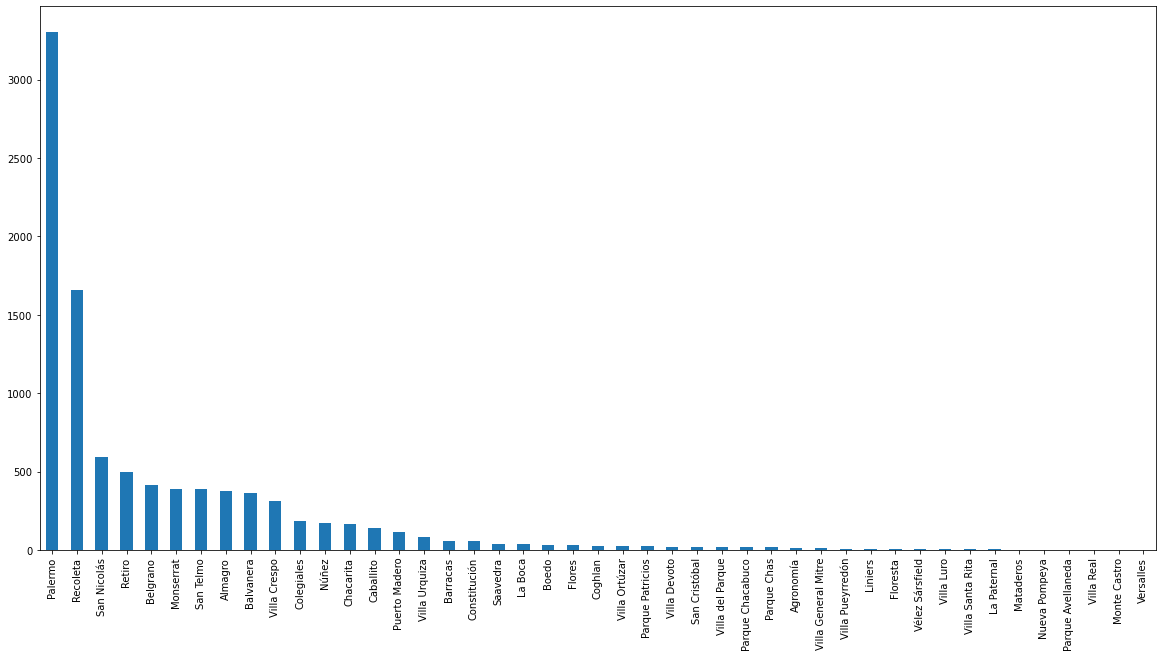

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(20, 10))
raw_data['neighbourhood'].value_counts().plot(kind='bar')
plt.show()
plt.clf()

<AxesSubplot:xlabel='neighbourhood', ylabel='room_type'>

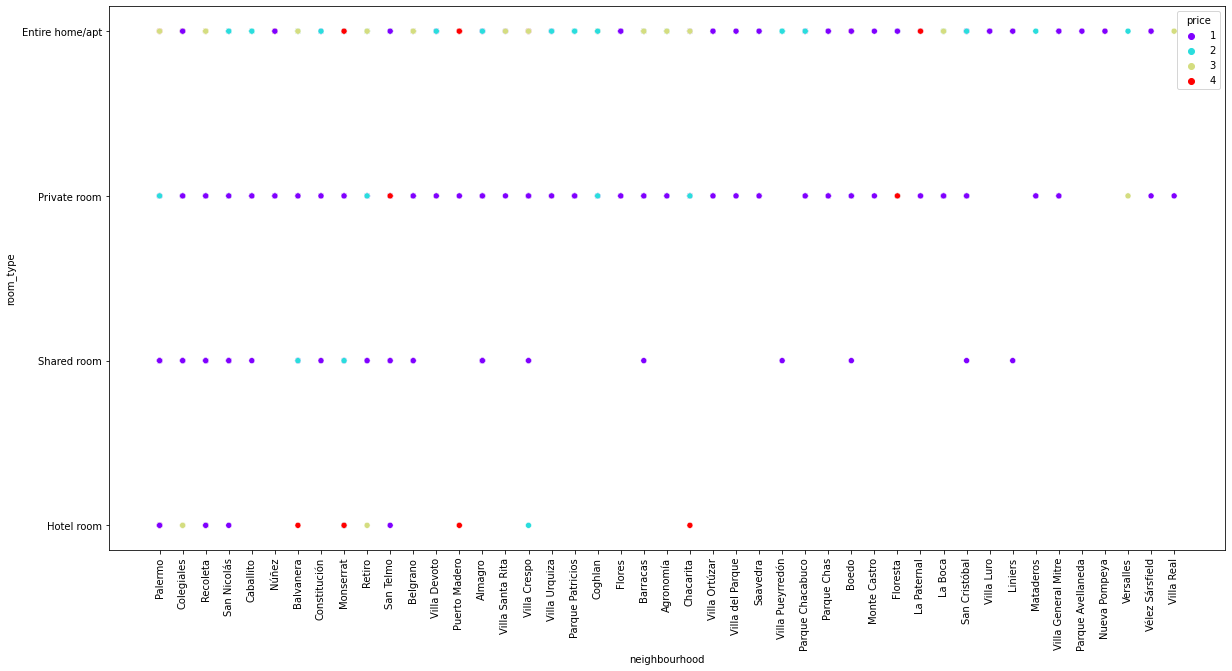

In [13]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.scatterplot(x='neighbourhood',hue='price', y='room_type',palette='rainbow',data=raw_data)

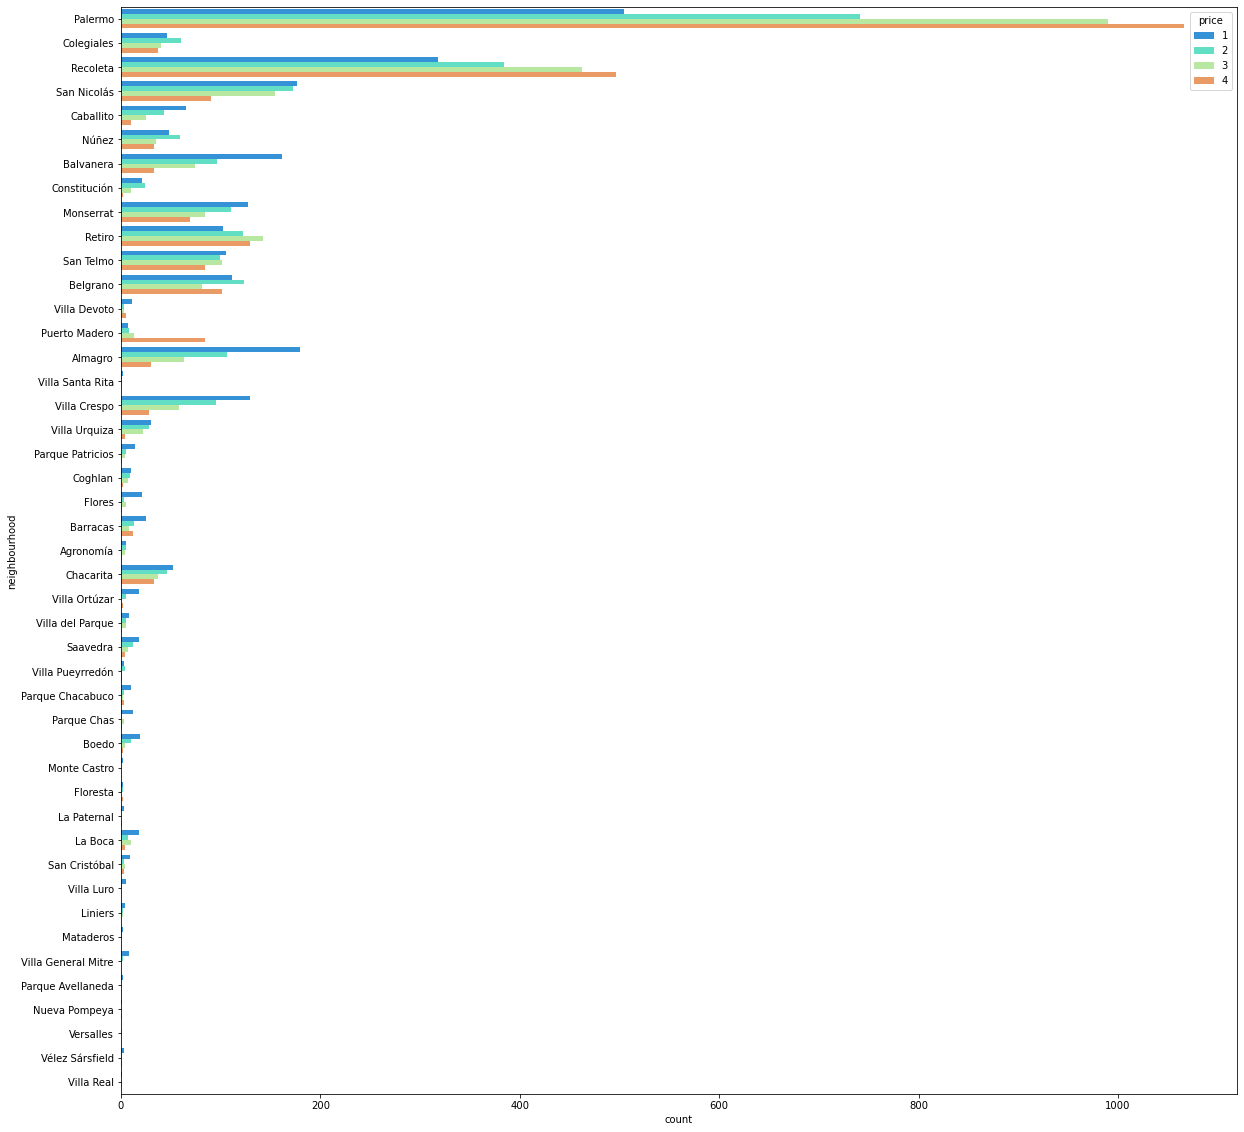

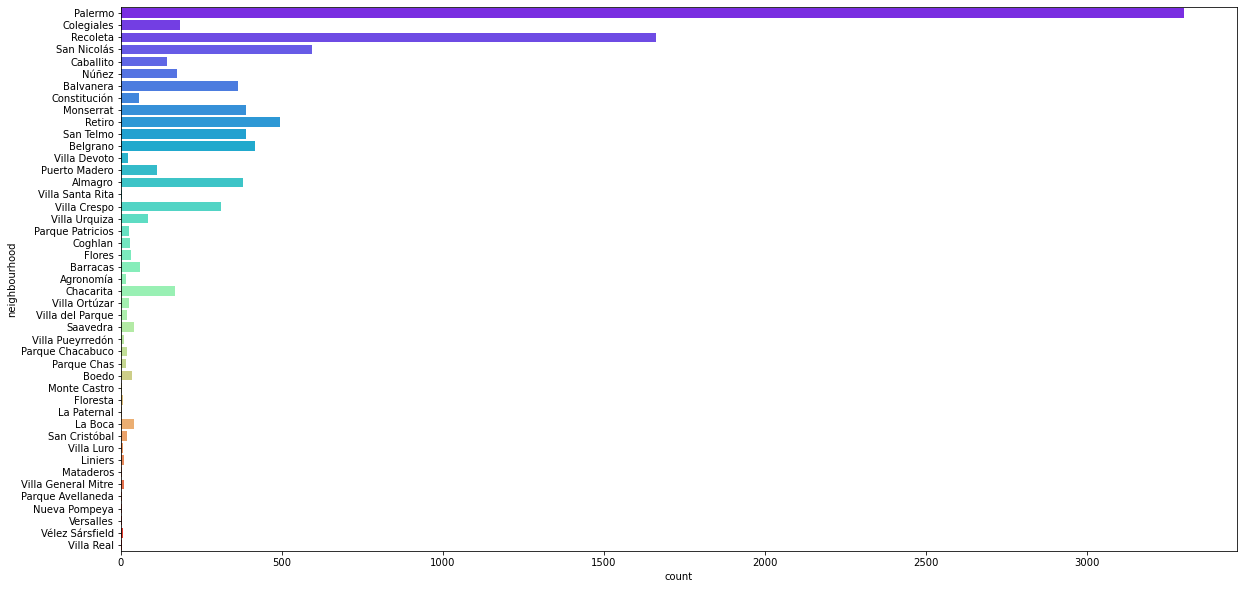

In [14]:
plt.figure(figsize=(20,20))
sns.countplot(y='neighbourhood',hue='price', palette='rainbow',data=raw_data, orient='h')
plt.show()
plt.figure(figsize=(20,10))
sns.countplot(y='neighbourhood', palette='rainbow',data=raw_data, orient='h')
plt.show()

# Exploring room features
### bathrooms, bedrooms, room types, beds, etc.

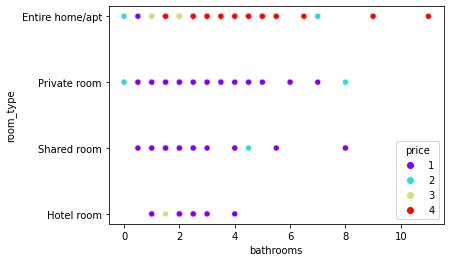

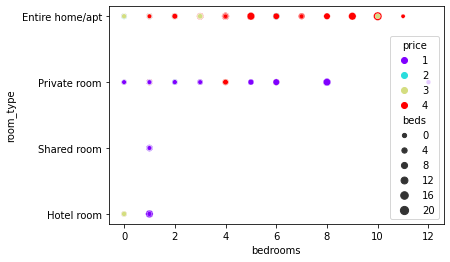

In [17]:
sns.scatterplot(x='bathrooms',hue='price', y='room_type',palette='rainbow',data=raw_data)
plt.show()
sns.scatterplot(x='bedrooms',hue='price', size='beds', y='room_type',palette='rainbow',data=raw_data)
plt.show()

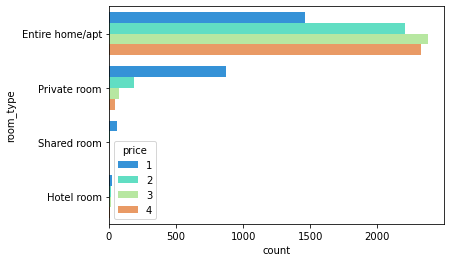

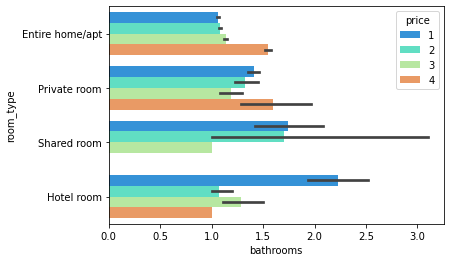

In [15]:
sns.countplot(y='room_type',hue='price', palette='rainbow',data=raw_data, orient='h')
plt.show()
sns.barplot(y='room_type',hue='price', x='bathrooms',palette='rainbow',data=raw_data)
plt.show()

c:\users\chengstark\anaconda3\envs\kaggle\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='room_type', ylabel='count'>

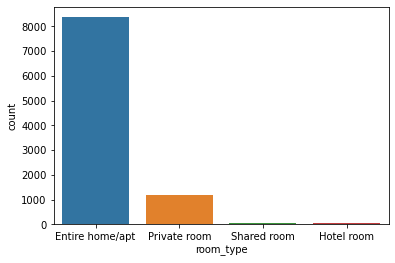

In [16]:
sns.countplot(raw_data['room_type'])

# Exploring superhost and its related features

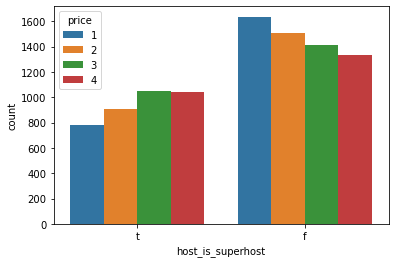

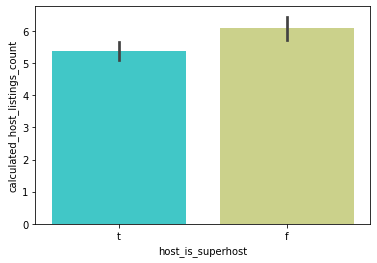

c:\users\stark\anaconda3\envs\kaggle\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


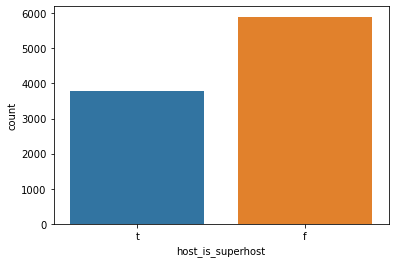

In [9]:
sns.countplot(x='host_is_superhost',hue='price', data=raw_data)
plt.show()
sns.barplot(x='host_is_superhost', y='calculated_host_listings_count',palette='rainbow',data=raw_data)
plt.show()
sns.countplot(raw_data['host_is_superhost'])
plt.show()

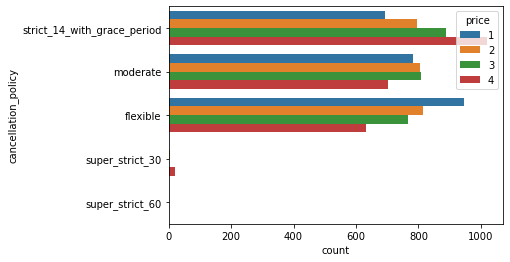

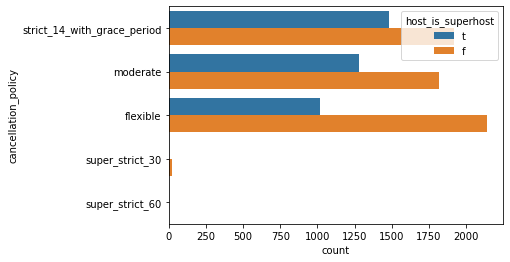

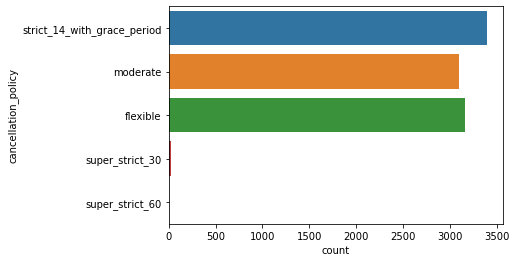

In [10]:
sns.countplot(y='cancellation_policy',hue='price', data=raw_data)
plt.show()
sns.countplot(y='cancellation_policy',hue='host_is_superhost', data=raw_data)
plt.show()
sns.countplot(y='cancellation_policy', data=raw_data)
plt.show()

# Exploring availablities and its related features
### Relationship between availability_365, instant_bookable and maximum_nights, etc.

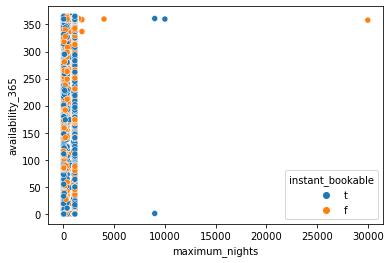

In [15]:
sns.scatterplot(y='availability_365',hue='instant_bookable', x='maximum_nights', data=raw_data)
plt.show()

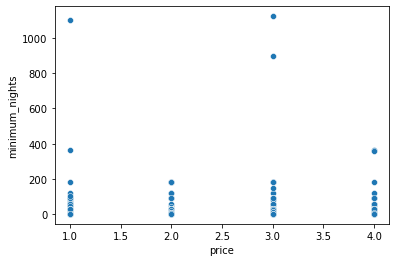

In [19]:
sns.scatterplot(y='minimum_nights', x='price', data=raw_data)
plt.show()

# Exploring some relationships between review related features

<AxesSubplot:>

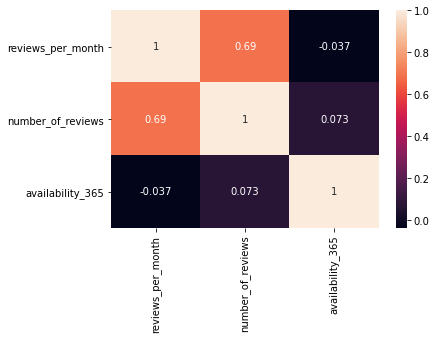

In [9]:
sns.heatmap(raw_data[['reviews_per_month','number_of_reviews','availability_365']].corr(),annot=True)

# Exploring interfeature relationships of numerical features

In [20]:
num_data = raw_data._get_numeric_data()
num_data

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,bathrooms,bedrooms,beds,cleaning_fee,guests_included,extra_people,maximum_nights,price
0,1,170,2.48,4,346,1.0,0,1,2092,1,0,365,2
1,1,11,0.57,1,0,1.0,1,1,558,1,0,15,1
2,3,2,0.08,19,360,1.0,0,1,1052,3,351,90,3
3,2,1,0.13,1,267,1.0,1,3,0,4,0,1125,2
4,2,31,1.54,5,365,1.0,1,3,2092,1,0,365,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,7,7,0.89,2,328,1.5,1,1,700,1,0,185,4
9677,1,5,0.43,1,0,2.0,2,5,1500,6,500,30,4
9678,3,1,0.30,28,174,1.0,0,2,3492,1,0,180,3
9679,2,28,0.58,1,0,2.0,3,3,900,1,0,1125,3


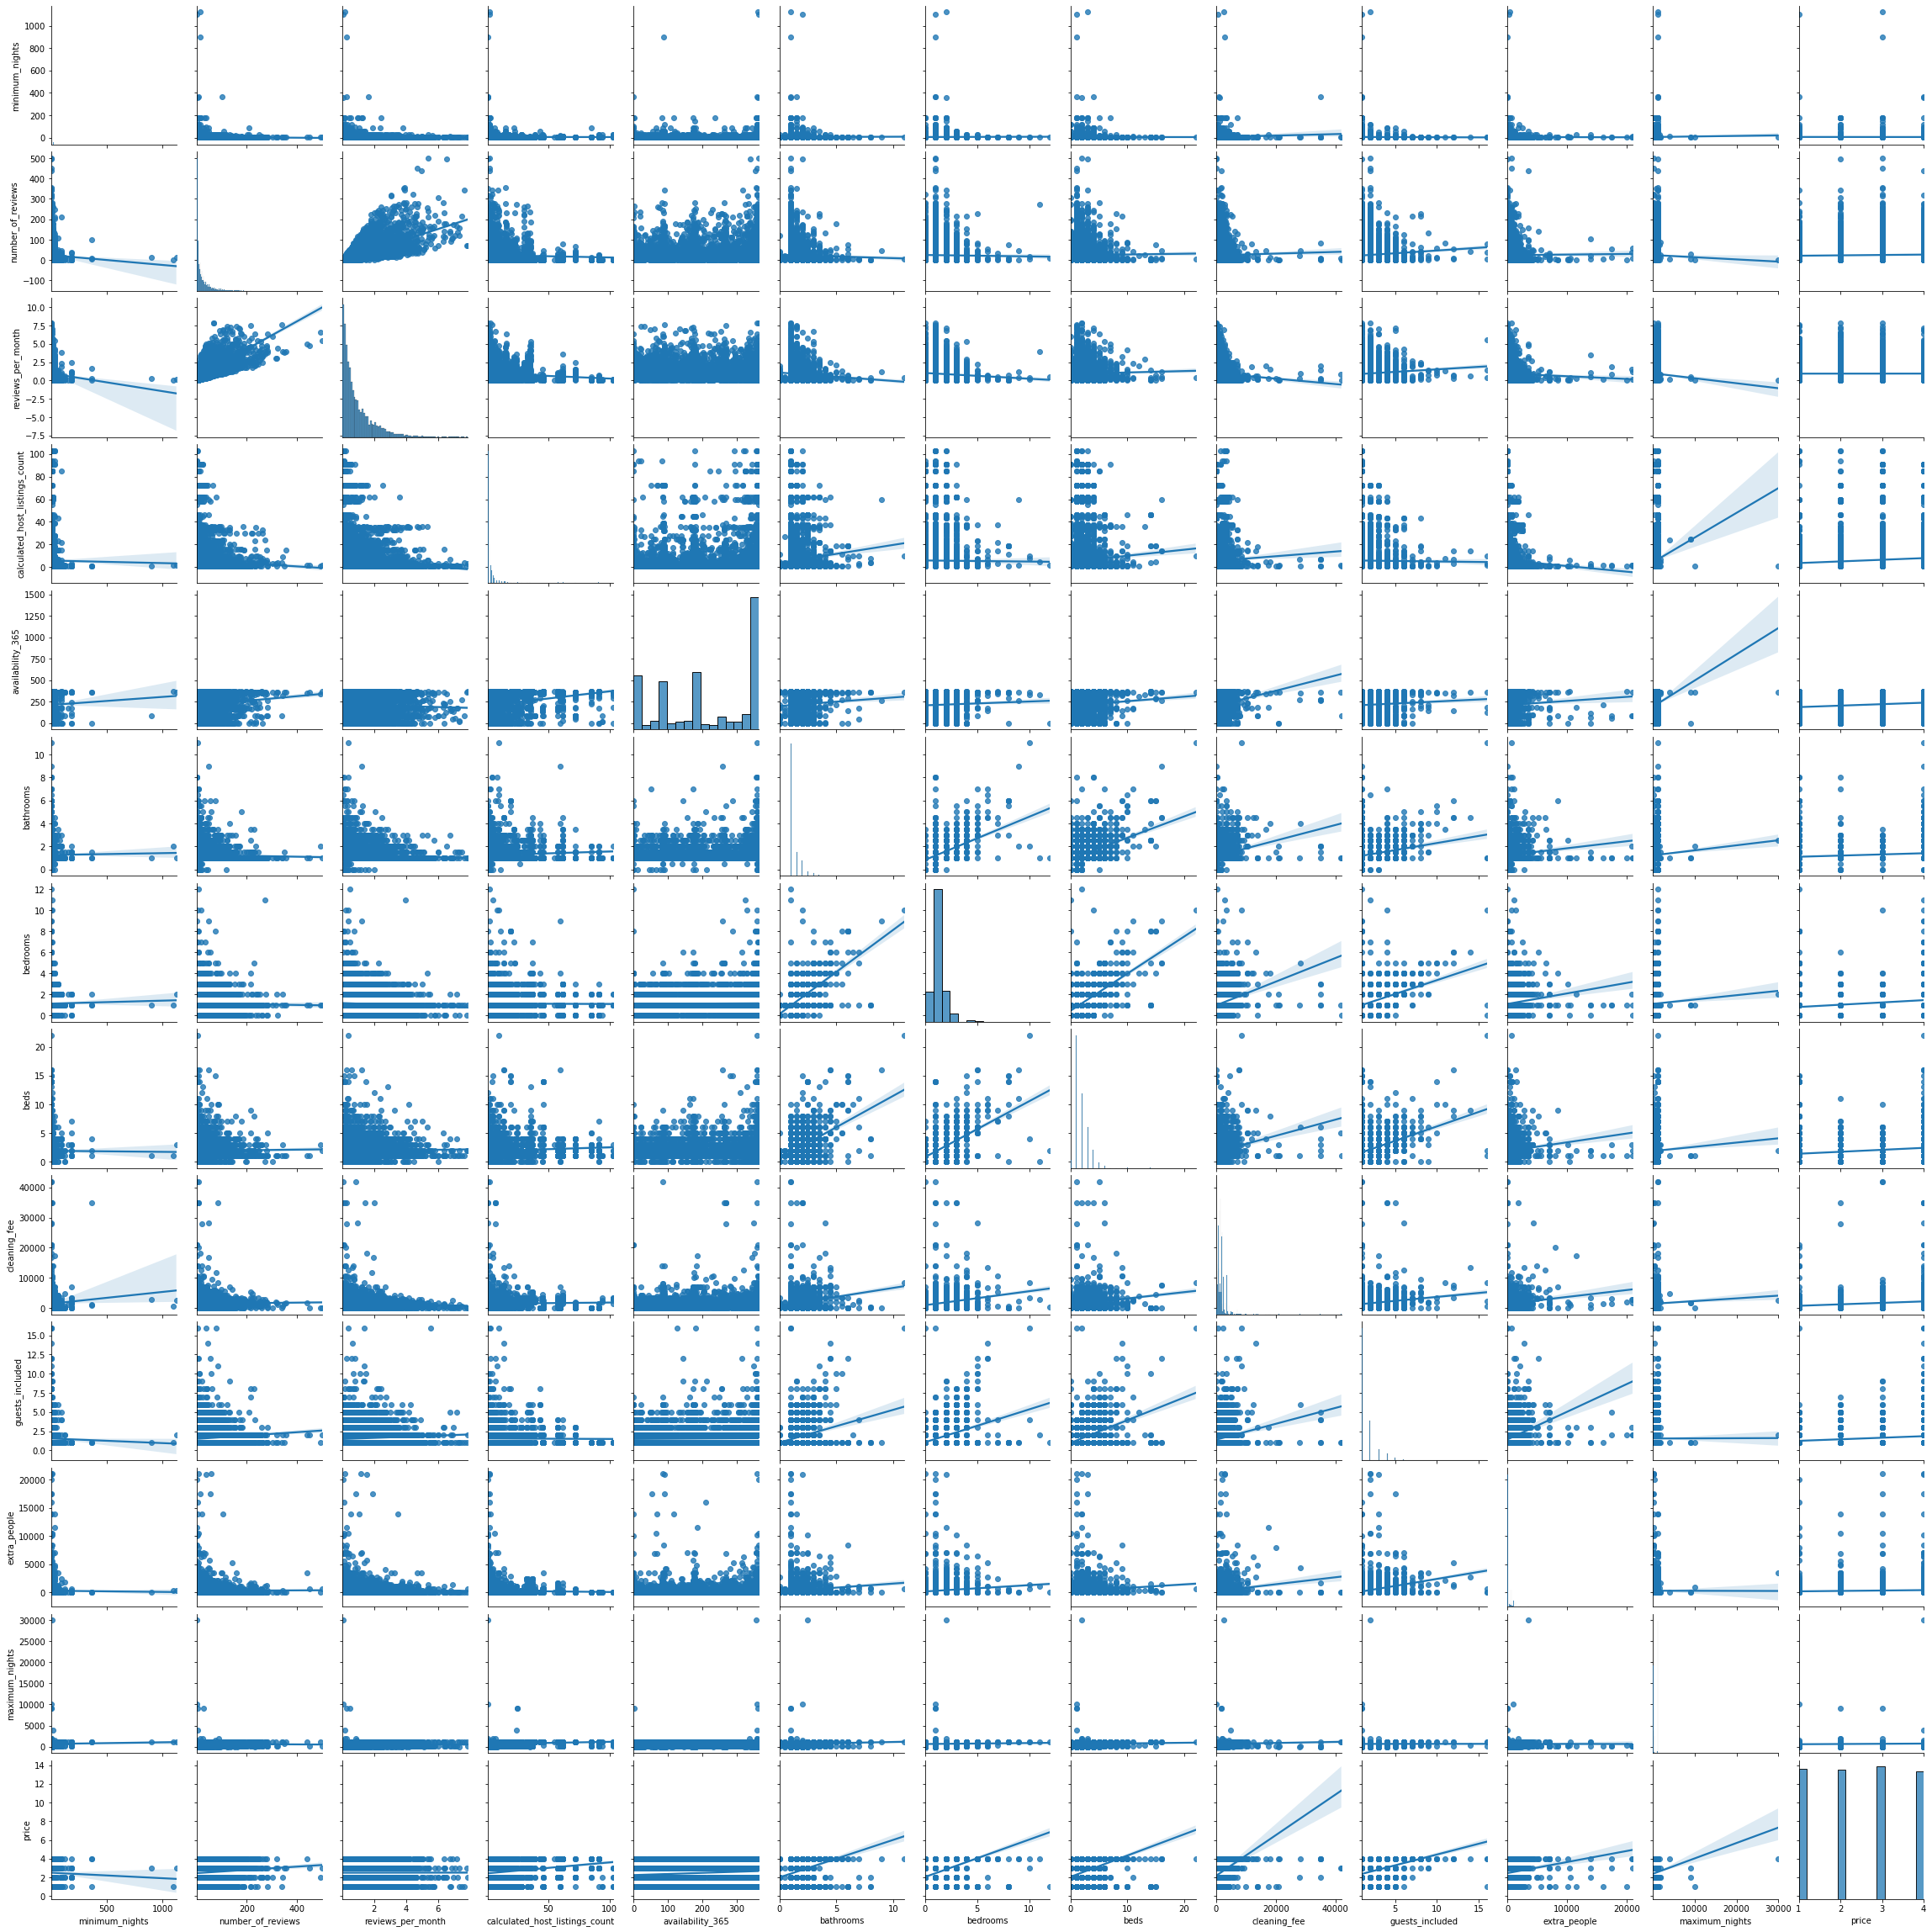

In [21]:
sns.pairplot(num_data, kind='reg')

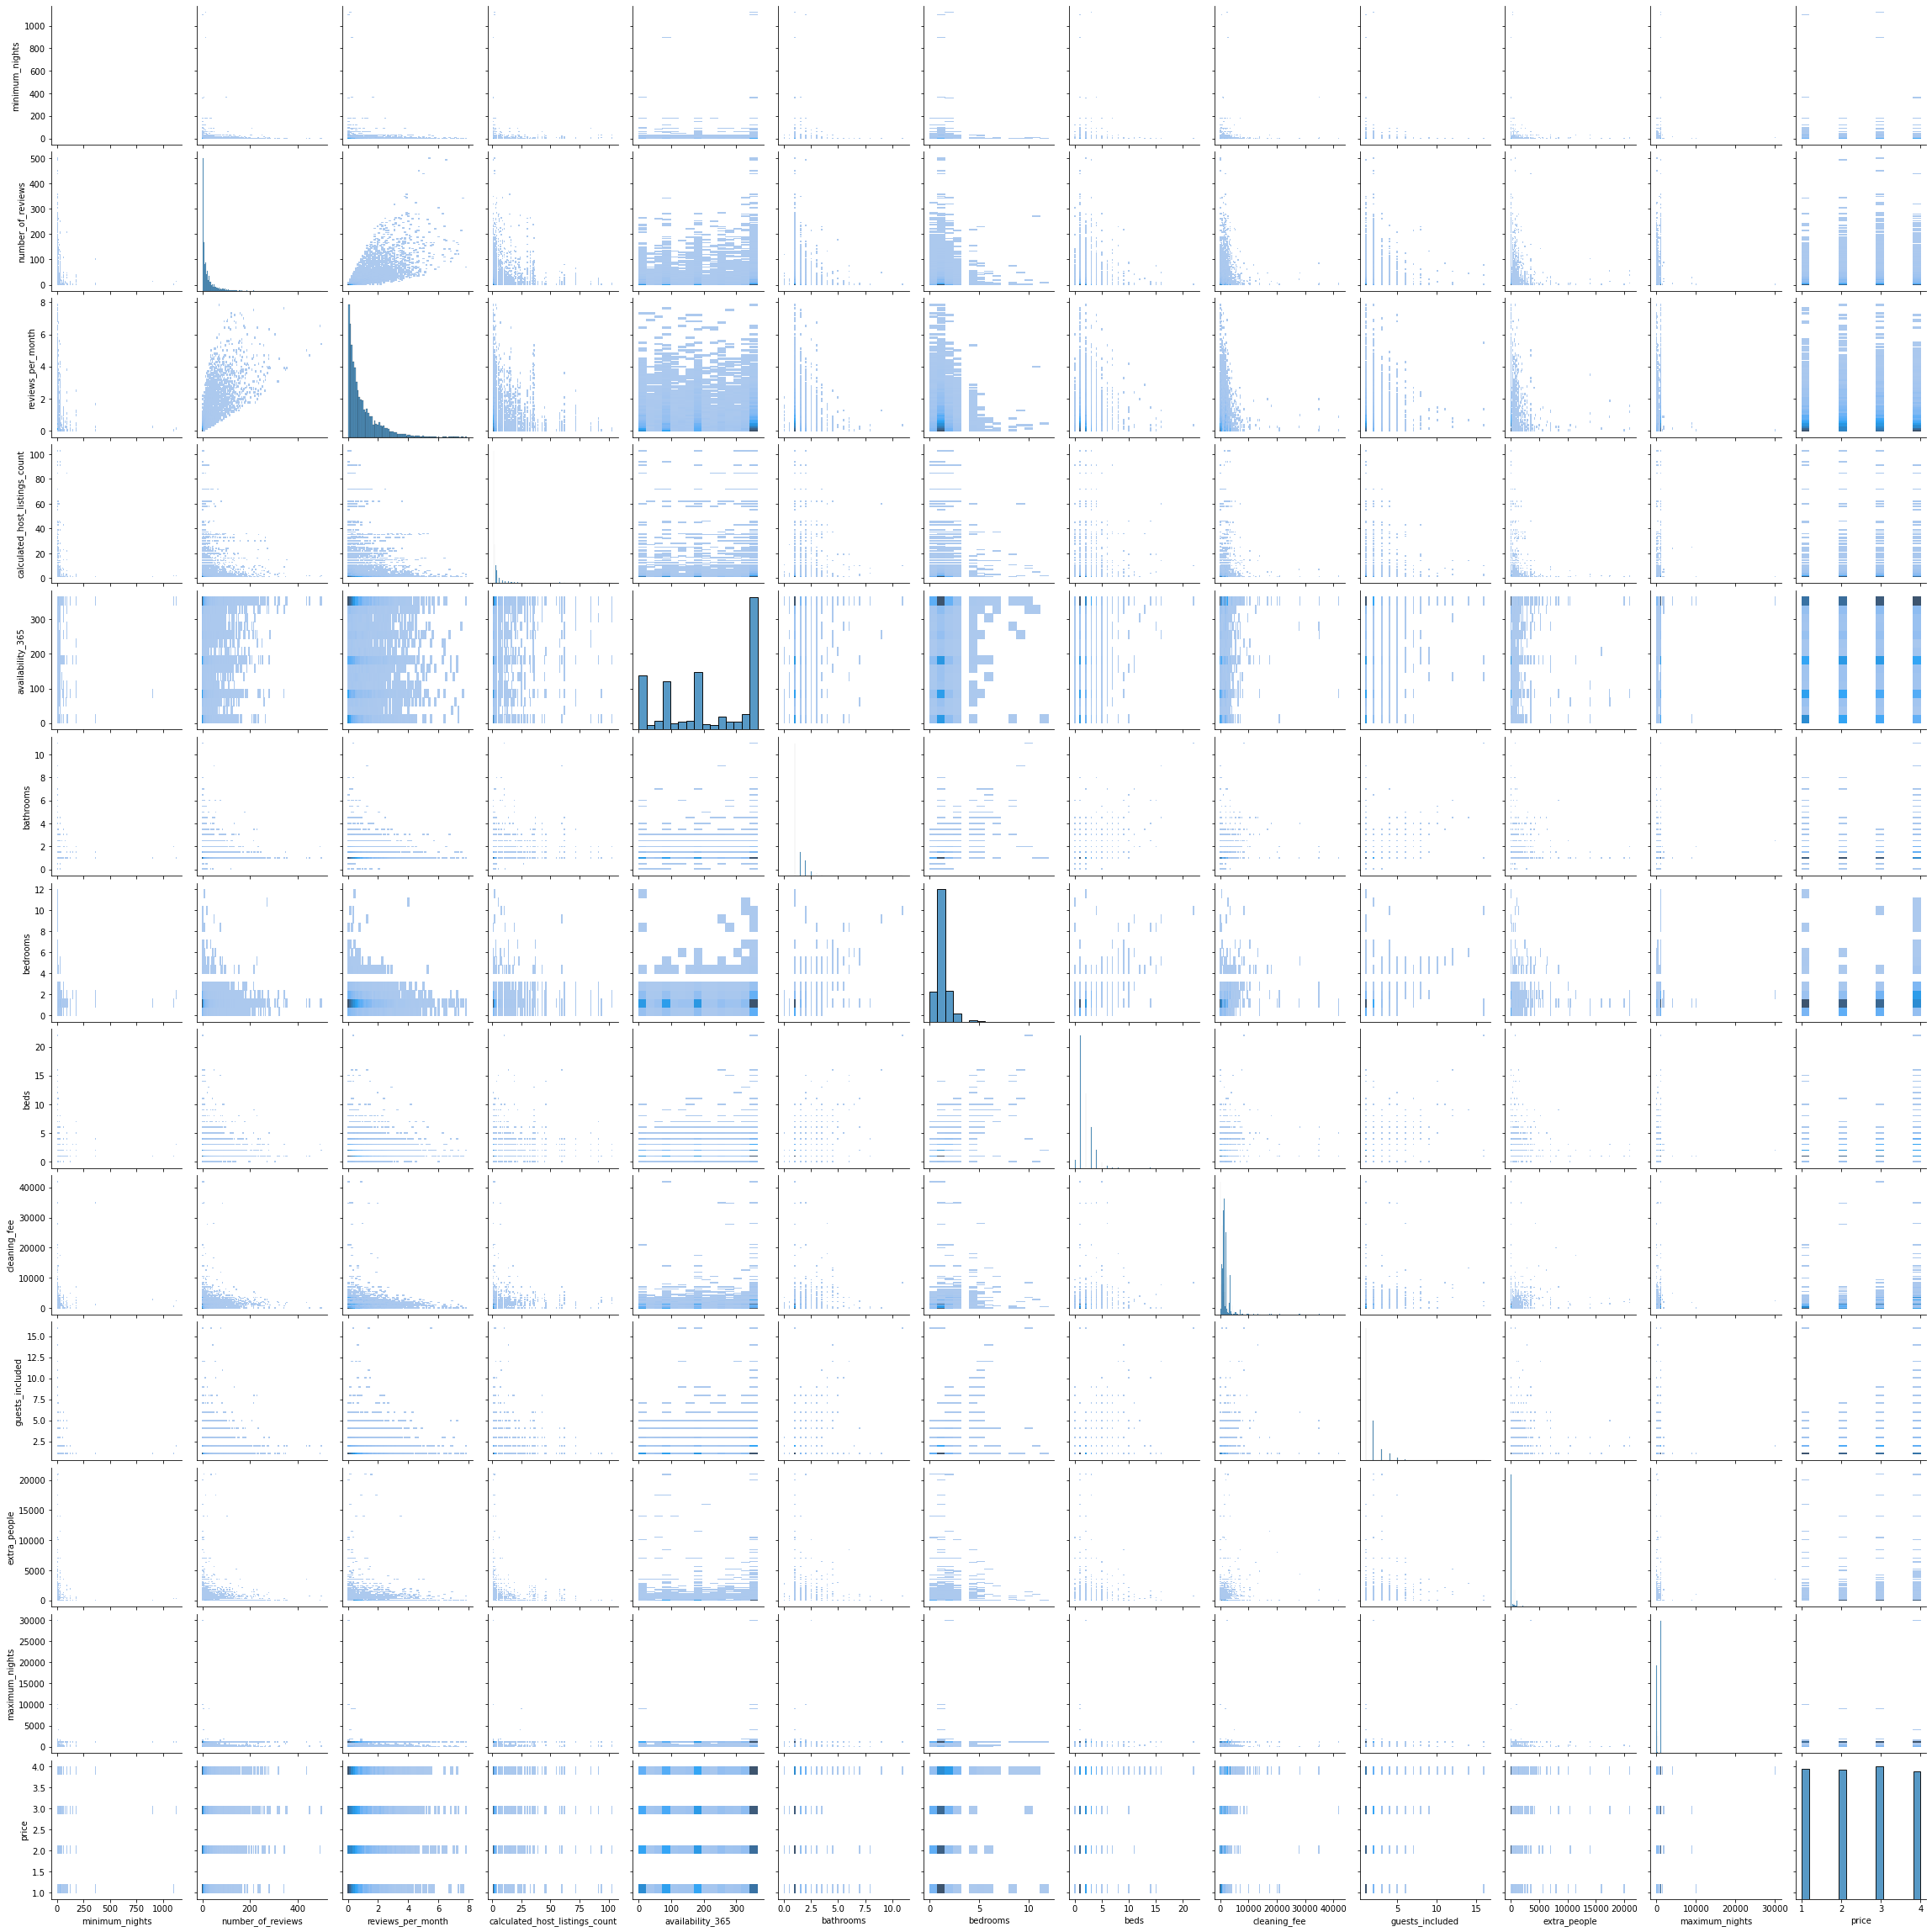

In [22]:
sns.pairplot(raw_data, kind='hist')

In [31]:
print(num_data.columns)

Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'bathrooms',
       'bedrooms', 'beds', 'cleaning_fee', 'guests_included', 'extra_people',
       'maximum_nights', 'price'],
      dtype='object')


# Check to see if there exists many outliers

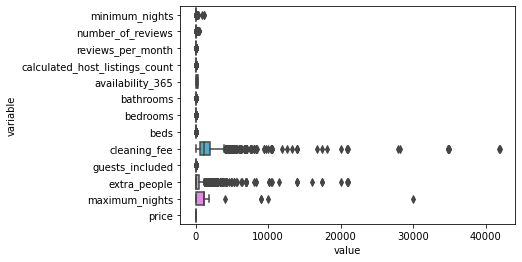

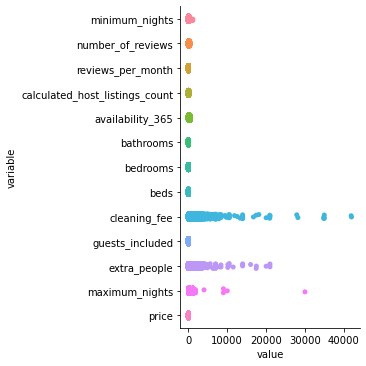

In [45]:
sns.boxplot(y="variable", x="value", data=pd.melt(num_data))
plt.show()
sns.catplot(y="variable", x="value", data=pd.melt(num_data))


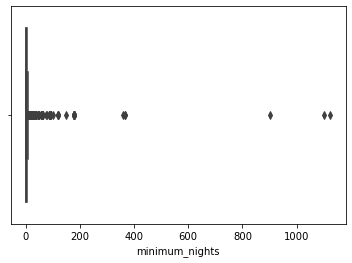

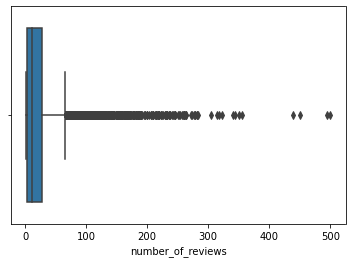

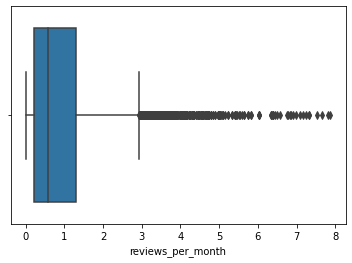

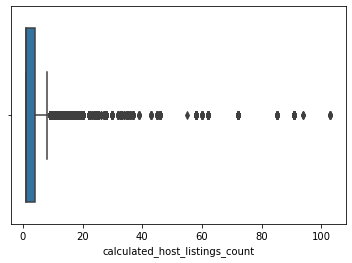

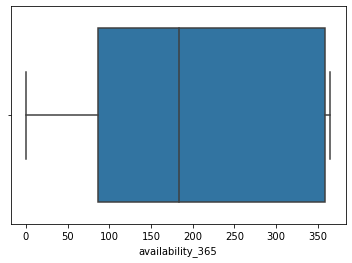

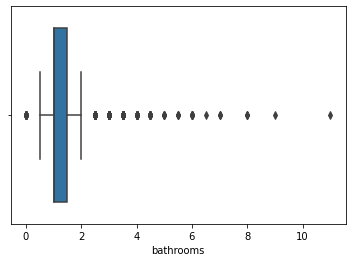

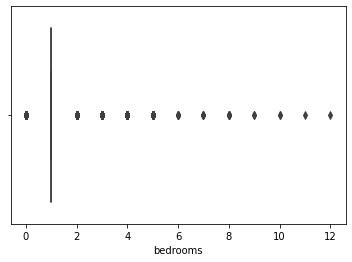

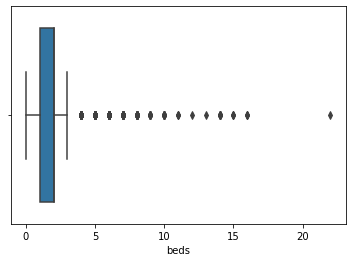

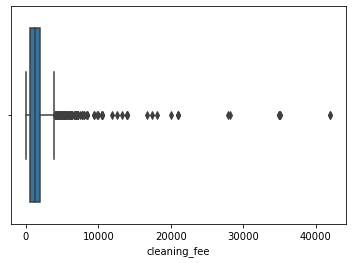

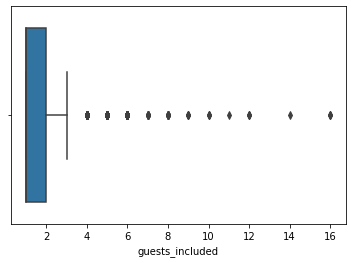

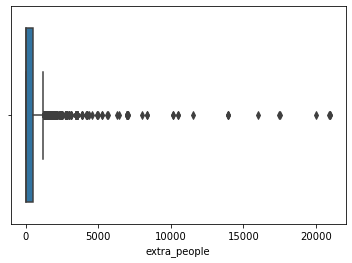

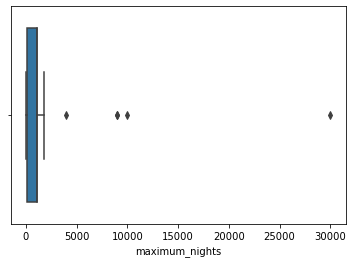

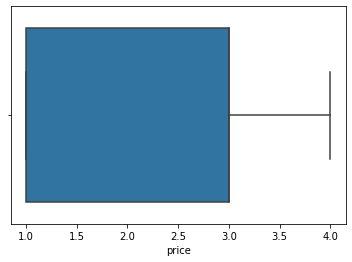

In [43]:
for c in num_data.columns:
    sns.boxplot(x=num_data[c])
    plt.show()

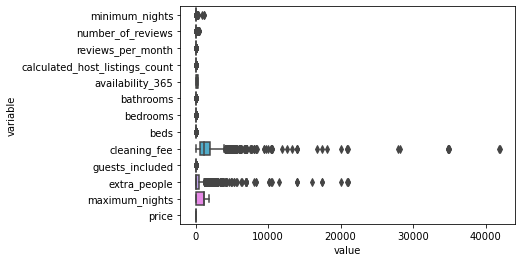

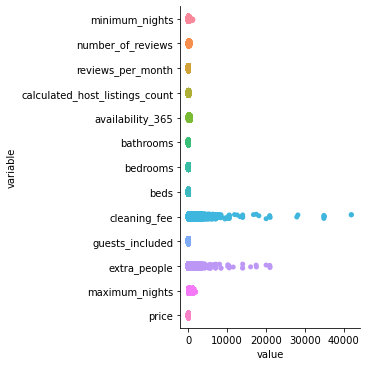

In [49]:
target = num_data['maximum_nights']
mean = target.mean()
std = target.std()
tol=4
filtered = num_data[(target > mean - tol*std) & (target < mean + tol*std)]

sns.boxplot(y="variable", x="value", data=pd.melt(filtered))
plt.show()
sns.catplot(y="variable", x="value", data=pd.melt(filtered))

# More digging with bed types and prices

In [5]:
print(raw_data['guests_included'].unique())

[ 1  3  4  2  6  5 16  9  8 10  7 12 11 14]


In [6]:
print(raw_data['beds'].unique())

[ 1  3  2  4  8  6  0  5 14 16 10  9 12 22  7 15 13 11]


In [8]:
print(raw_data['bed_type'].unique())

['Real Bed' 'Futon' 'Pull-out Sofa' 'Couch' 'Airbed']


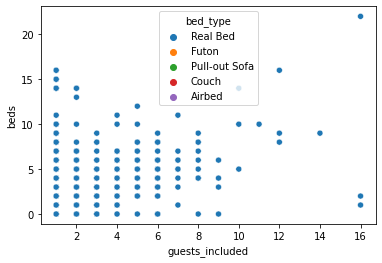

In [11]:
sns.scatterplot(y='beds',hue='bed_type', x='guests_included', data=raw_data)
plt.show()

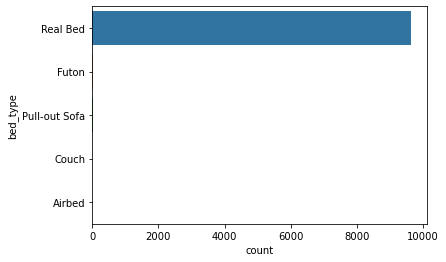

(array(['Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed'],
      dtype=object), array([   2,    3,   12,   23, 9641], dtype=int64))


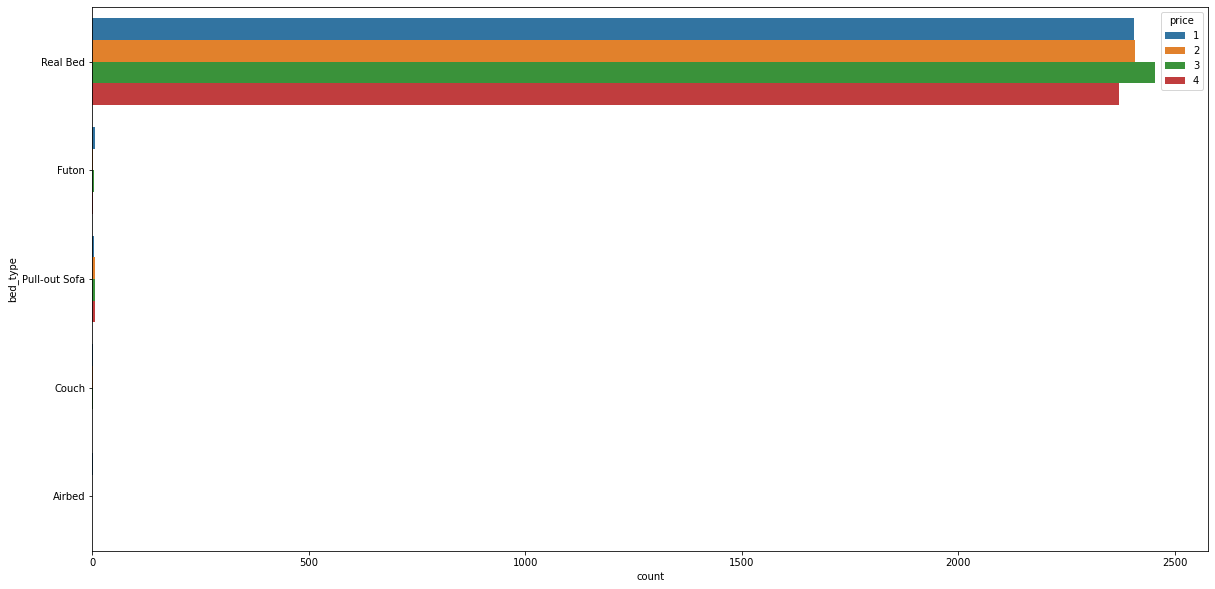

In [10]:
sns.countplot(y='bed_type', data=raw_data)
plt.show()
print(np.unique(raw_data['bed_type'], return_counts=True))
plt.figure(figsize=(20,10))
sns.countplot(y='bed_type', hue='price', data=raw_data)
plt.show()